In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import os
import cv2

## Dataset preparation

In [2]:
DATASET_DIR = '../datasplit'  # path to your dataset

In [3]:
# Example code for splitting if needed
import os
import shutil
from sklearn.model_selection import train_test_split

# Path to your dataset
source_dir = '../dataset'
train_dir = '../dataset/train/'
val_dir = '../dataset/validation/'
test_dir = '../dataset/test/'
data_split_dir = '../datasplit'

# Create data split directory
os.makedirs(data_split_dir, exist_ok=True)

# For each country folder
for country in os.listdir(source_dir):
    country_path = os.path.join(source_dir, country)
    if os.path.isdir(country_path):
        # Create country directories in train, val, test
        os.makedirs(os.path.join(train_dir, country), exist_ok=True)
        os.makedirs(os.path.join(val_dir, country), exist_ok=True)
        os.makedirs(os.path.join(test_dir, country), exist_ok=True)
        
        # Get all images in this country folder
        images = [f for f in os.listdir(country_path) if f.endswith(('.jpg', '.png'))]
        
        # Split into train, val, test
        train_imgs, test_val_imgs = train_test_split(images, test_size=0.3, random_state=42)
        val_imgs, test_imgs = train_test_split(test_val_imgs, test_size=0.5, random_state=42)
        
        # Copy images to their respective directories
        for img in train_imgs:
            shutil.copy(os.path.join(country_path, img), os.path.join(train_dir, country, img))
        for img in val_imgs:
            shutil.copy(os.path.join(country_path, img), os.path.join(val_dir, country, img))
        for img in test_imgs:
            shutil.copy(os.path.join(country_path, img), os.path.join(test_dir, country, img))

shutil.move(train_dir, data_split_dir)
shutil.move(val_dir, data_split_dir)
shutil.move(test_dir, data_split_dir)

'../datasplit/test'


Train set:
France: 2501 images
Japan: 2688 images
South Africa: 828 images


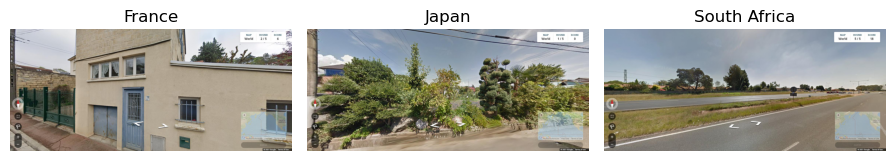


Validation set:
France: 536 images
Japan: 576 images
South Africa: 177 images


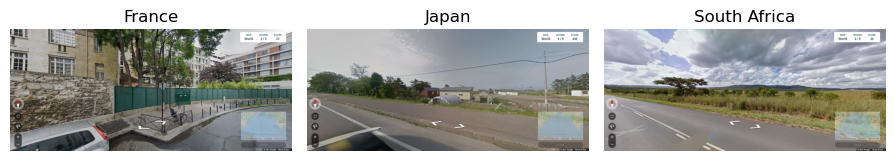


Test set:
France: 536 images
Japan: 576 images
South Africa: 178 images


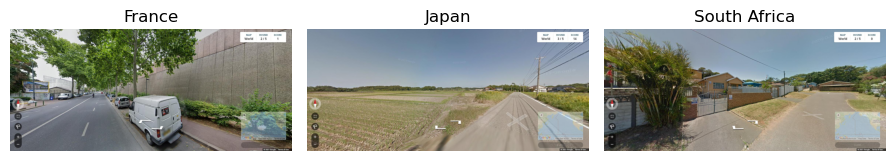

In [10]:
# Check class distribution
for split in ['train', 'validation', 'test']:
    print(f"\n{split.capitalize()} set:")
    for country in os.listdir(f'{DATASET_DIR}/{split}/'):
        count = len(os.listdir(f'{DATASET_DIR}/{split}/{country}/'))
        print(f"{country}: {count} images")
        
    # Display sample images
    plt.figure(figsize=(15, 10))
    for i, country in enumerate(list(os.listdir(f'{DATASET_DIR}/{split}/'))):
        country_path = os.path.join(f'{DATASET_DIR}/{split}/', country)
        sample_img = os.path.join(country_path, os.listdir(country_path)[0])
        img = cv2.imread(sample_img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.title(country)
        plt.axis('off')
    plt.tight_layout()
    plt.show()